# Step 3: Create the Model

Install missing libraries

In [1]:
!pip install keras
!pip install scikit-plot
!pip install blimpy
!pip install opencv-python-headless

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cd/c1/50a758e8247561e58cb87305b1e90b171b8c767b15b12a1734001f41d356/joblib-0.13.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/92/b055b75952d7fdb2a3d1601bd83d7c13417bd85912587a55ea37be5f6c71/Cython-0.29.11-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e3/0f/c199189d9f2a6b1a60177788b00a6fcf2a7fa8f3d63f17b2e496810dade9/astropy-2.0.14-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d8/e9/73246a565c34c5f203dd78bc2382e0e93aa7a249cdaeba709099eb1bc701/pytest-3.6.4-py2.py3-none-any.whl
  Using cached https:

Import relevant libraries

In [2]:
import os
from tensorflow import keras
import numpy as np
import math
#from PIL import Image
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from keras.models import load_model
from keras.preprocessing import image
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import google.datalab.storage as storage #To access cloud storage buckets
import random
import cv2
warnings.filterwarnings('ignore')

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Get Images Lists

In [6]:
# line_train = !ls train/line/** | wc -l
# print(str(line_train) + ' line train files')
# line_valid = !ls valid/line/** | wc -l
# print(str(line_valid) + ' line valid files')
# line_test = !ls test/line/** | wc -l
# print(str(line_test) + ' line test files')

# wibble_train = !ls train/wibble/** | wc -l
# print(str(wibble_train) + ' wibble train files')
# wibble_valid = !ls valid/wibble/** | wc -l
# print(str(wibble_valid) + ' wibble valid files')
# wibble_test = !ls test/wibble/** | wc -l
# print(str(wibble_test) + ' wibble test files')

# curve_train = !ls train/curve/** | wc -l
# print(str(curve_train) + ' curve train files')
# curve_valid = !ls valid/curve/** | wc -l
# print(str(curve_valid) + ' curve valid files')
# curve_test = !ls test/curve/** | wc -l
# print(str(curve_test) + ' curve test files')

# noise_train = !ls train/noise/** | wc -l
# print(str(noise_train) + ' noise train files')
# noise_valid = !ls valid/noise/** | wc -l
# print(str(noise_valid) + ' noise valid files')
# noise_test = !ls test/noise/** | wc -l
# print(str(noise_test) + ' noise test files')

# chopped_line_train = !ls train/chopped_line/** | wc -l
# print(str(chopped_line_train) + ' chopped_line train files')
# chopped_line_valid = !ls valid/chopped_line/** | wc -l
# print(str(chopped_line_valid) + ' chopped_line valid files')
# chopped_line_test = !ls test/chopped_line/** | wc -l
# print(str(chopped_line_test) + ' chopped_line test files')

# brightpixel_train = !ls train/brightpixel/** | wc -l
# print(str(brightpixel_train) + ' brightpixel train files')
# brightpixel_valid = !ls valid/brightpixel/** | wc -l
# print(str(brightpixel_valid) + ' brightpixel valid files')
# brightpixel_test = !ls test/brightpixel/** | wc -l
# print(str(brightpixel_test) + ' brightpixel test files')

Setup the training

In [8]:
train_dir = 'train/'
validation_dir = 'valid/'
test_dir = 'test/'

img_dim  = 197

In [9]:
#Generators
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

# Note that the validation data shouldn't be augmented!
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)  
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255) 

In [10]:
training_batch_size = 32
validation_batch_size = 32

train_generator = train_datagen.flow_from_directory(
  train_dir,                                                  
  #classes = ('noise', 'line', 'wibble', 'chopped_line', 'curve', 'brightpixel'),
  classes = ('noise', 'line', 'wibble', 'chopped_line', 'curve'),
  target_size = (img_dim, img_dim),            
  batch_size = training_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 42500 images belonging to 5 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  #classes = ('noise', 'line', 'wibble', 'chopped_line', 'curve', 'brightpixel'),
  classes = ('noise', 'line', 'wibble', 'chopped_line', 'curve'),
  target_size = (img_dim, img_dim),
  batch_size = validation_batch_size,
  class_mode = "categorical",
  shuffle = True,
  seed = 123)

Found 5000 images belonging to 5 classes.


In [12]:
#test_size = 3000
test_size = 2500
test_batch_size = 1

test_generator = test_datagen.flow_from_directory(
  test_dir,
  #classes = ('noise', 'line', 'wibble', 'chopped_line', 'curve', 'brightpixel'),
  classes = ('noise', 'line', 'wibble', 'chopped_line', 'curve'),
  target_size = (img_dim, img_dim),
  batch_size = test_batch_size,
  class_mode = "categorical",
  shuffle = False)

Found 2500 images belonging to 5 classes.


Specify the model

In [13]:
input_shape = (img_dim, img_dim, 3)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (10, 10), input_shape=input_shape))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(32, (5, 5)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(img_dim, activation="relu"))
model.add(keras.layers.Dropout(0.25))
#model.add(keras.layers.Dense(6, activation="softmax"))
model.add(keras.layers.Dense(5, activation="softmax"))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 188, 188, 32)      9632      
_________________________________________________________________
activation_1 (Activation)    (None, 188, 188, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 94, 94, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 90, 90, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 32)        0         
__________

Set the optimiser and then train

In [21]:
opt = keras.optimizers.RMSprop(lr=1e-4, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss = "categorical_crossentropy",  optimizer = opt, metrics=["accuracy"])

In [23]:
#Train

training_step_size = 32
validation_step_size = 32

history = model.fit_generator(
  train_generator,
  steps_per_epoch = training_step_size,
  epochs = 20,
  validation_data = validation_generator,
  validation_steps = validation_step_size,
  verbose = 1,
)

Epoch 1/20
32/32 [==============================] - 163s 5s/step - loss: 1.6001 - acc: 0.2754 - val_loss: 1.5357 - val_acc: 0.2979
Epoch 2/20
32/32 [==============================] - 157s 5s/step - loss: 1.5096 - acc: 0.3184 - val_loss: 1.5078 - val_acc: 0.3125
Epoch 3/20
32/32 [==============================] - 172s 5s/step - loss: 1.5045 - acc: 0.2979 - val_loss: 1.5044 - val_acc: 0.2969
Epoch 4/20
32/32 [==============================] - 165s 5s/step - loss: 1.4737 - acc: 0.3301 - val_loss: 1.4870 - val_acc: 0.3262
Epoch 5/20
32/32 [==============================] - 162s 5s/step - loss: 1.4709 - acc: 0.3193 - val_loss: 1.4803 - val_acc: 0.3389
Epoch 6/20
32/32 [==============================] - 158s 5s/step - loss: 1.4430 - acc: 0.3506 - val_loss: 1.4002 - val_acc: 0.4980
Epoch 7/20
32/32 [==============================] - 217s 7s/step - loss: 1.3158 - acc: 0.4678 - val_loss: 1.3221 - val_acc: 0.5264
Epoch 8/20
32/32 [==============================] - 162s 5s/step - loss: 1.1975 - a

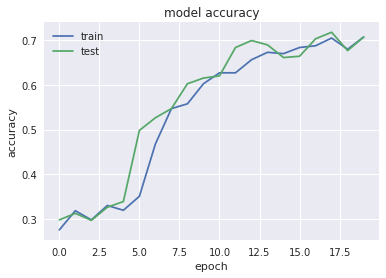

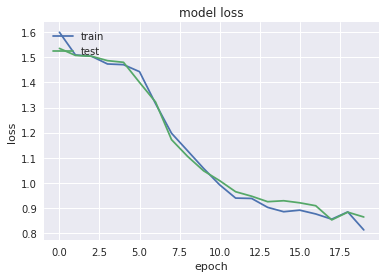

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Save the model then back it up to cloud storage

In [25]:
model.save('seti_bespoke_20190705_RH_v01.h5')

In [20]:
!gsutil cp seti_bespoke_20190628_RH_v01.h5 gs://seti_model_backup #copy to bucket



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://seti_bespoke_20190628_RH_v01.h5 [Content-Type=application/octet-stream]...
\ [1 files][ 42.9 MiB/ 42.9 MiB]                                                
Operation completed over 1 objects/42.9 MiB.                                     


Make predictions

In [15]:
predictions = model.predict_generator(test_generator, steps = test_size, verbose = 1)

2500/2500 [==============================] - 13s 5ms/step


In [16]:
df = pd.DataFrame(predictions)
df['filename'] = test_generator.filenames
df['truth'] = ''
df['truth'] = df['filename'].str.split('/', 1, expand = True)
#df['prediction_index'] = df[[0,1,2,3,4,5]].idxmax(axis=1)
df['prediction_index'] = df[[0,1,2,3,4]].idxmax(axis=1)

df['prediction'] = ''
df['prediction'][df['prediction_index'] == 0] = 'noise'
df['prediction'][df['prediction_index'] == 1] = 'line'
df['prediction'][df['prediction_index'] == 2] = 'wibble'
df['prediction'][df['prediction_index'] == 3] = 'chopped_line'
df['prediction'][df['prediction_index'] == 4] = 'curve'
#df['prediction'][df['prediction_index'] == 5] = 'brightpixel'

In [17]:
cm = confusion_matrix(df['truth'], df['prediction'])

cm_df = pd.DataFrame(cm)

#cm_df.columns = ['noise', 'line', 'wibble', 'chopped_line', 'curve', 'brightpixel']
#cm_df['signal'] = ('noise', 'line', 'wibble', 'chopped_line', 'curve', 'brightpixel')

cm_df.columns = ['noise', 'line', 'wibble', 'chopped_line', 'curve']
cm_df['signal'] = ('noise', 'line', 'wibble', 'chopped_line', 'curve')

cm_df

,noise,line,wibble,chopped_line,curve,signal
0,414,23,11,43,9,noise
1,2,459,7,29,3,line
2,1,68,396,22,13,wibble
3,6,27,2,448,17,chopped_line
4,1,11,63,34,391,curve


In [18]:
accuracy = accuracy_score(df['truth'], df['prediction'])
accuracy

0.8432